In [0]:
# Permission to access Google Drive

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Traceback (most recent call last):
  File "/usr/bin/add-apt-repository", line 136, in <module>
    shortcut = shortcut_handler(line)
  File "/usr/lib/python3/dist-packages/softwareproperties/SoftwareProperties.py", line 1020, in shortcut_handler
    ret = factory(shortcut)
  File "/usr/lib/python3/dist-packages/softwareproperties/ppa.py", line 398, in shortcut_handler
    return PPAShortcutHandler(shortcut)
  File "/usr/lib/python3/dist-packages/softwareproperties/ppa.py", line 355, in __init__
    info = get_ppa_info(self.shortcut)
  File "/usr/lib/python3/dist-packages/softwareproperties/ppa.py", line 326, in get_ppa_info
    ret = get_ppa_info_from_lp(user, ppa)
  File "/usr/lib/python3/dist-packages/softwareproperties/ppa.py", line 101, in get_ppa_info_from_lp
    return get_info_from_lp(lp_url)
  File "/usr/lib/python3/dist-packages/softwareproperties/ppa.py", line 95, in get_info_from_lp
    return get_info_fro

In [0]:
# Mount Google Drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/items.zip'

url = urlopen(URL)
output = open('items.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('items.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [3]:
# Import data and keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import Activation, SpatialDropout2D
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import os

files = os.listdir('./dataset/items')
for name in files:
    print(name)

items_label.npy
items_image.npy


In [0]:
x1_raw = np.load('./dataset/items/items_image.npy')
y1_raw = np.load('./dataset/items/items_label.npy')

x1_test = np.array([])
y1_test = np.array([])

# Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [0]:
y1_train = []
filterLbls = [ 'items_wearable_torso']
#             'environment_building',
#             'environment_castle',
#             'environment_cave',
#             'environment_decor',
#             'environment_doors',
#             'environment_gateways',
#             'environment_ground',
#             'environment_overworld',
#             'environment_sigils',
#             'environment_town',
#             'environment_wall',
#             'environment_water']
firstTime = True
for i in range(y1_raw.shape[0]):
  
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_raw[i])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)
    
y1_train = np.array(y1_train)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  featurewise_center = True,
  featurewise_std_normalization = True,
  rotation_range = 60,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2
)

datagen.fit(x1_train)

In [12]:
# Encoder
inputShape = (32,32,4)

encoder = Sequential()
encoder.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=inputShape)) 
encoder.add(SpatialDropout2D(0.25))
encoder.add(Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same'))
encoder.add(Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same'))

print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        592       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# Decoder1
codeShape = (8,8,64)

decoder = Sequential()
decoder.add(Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape))
decoder.add(Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same'))
decoder.add(Conv2DTranspose(4, (3,3), activation='sigmoid', padding='same'))

print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 4)         580       
Total params: 23,668
Trainable params: 23,668
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# Autoencoder
inputImage1 = Input(shape=inputShape)
x = encoder(inputImage1)
x = decoder(x)
autoencoder = Model(inputImage1, x)

print(autoencoder.summary())
print(x1_train.shape)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 64)          23728     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 4)         23668     
Total params: 47,396
Trainable params: 47,396
Non-trainable params: 0
_________________________________________________________________
None
(156, 32, 32, 4)


In [55]:
encoder.trainable = True
decoder.trainable = True
autoencoder.trainable = True

history = autoencoder.fit(x1_train, x1_train, epochs=100, batch_size=1, shuffle=True)

Epoch 1/100
156/156 [==============================] - 2s 11ms/step - loss: 0.1411
Epoch 2/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1481
Epoch 3/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1418
Epoch 4/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1416
Epoch 5/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1409
Epoch 6/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1474
Epoch 7/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1447
Epoch 8/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1417
Epoch 9/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1421
Epoch 10/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1414
Epoch 11/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1472
Epoch 12/100
156/156 [==============================] - 2s 10ms/step - loss: 0.1412
E

(32, 32, 4)
(32, 32, 4)


(-0.5, 31.5, 31.5, -0.5)

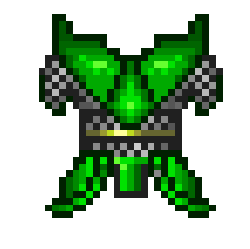

In [68]:
import random
x = random.randint(0,64)
randImg = np.reshape(x1_train[x], (1, 32, 32, 4)) 

resultImg = encoder.predict(randImg, batch_size=1)
resultImg = decoder.predict(resultImg, batch_size=1)
randImg = randImg.reshape(32,32,4)
resultImg = resultImg.reshape(32,32,4)

print(randImg.shape)
print(resultImg.shape)
from matplotlib import pyplot as plt

plt.tight_layout()
plt.imshow(randImg)
plt.axis('off')



(-0.5, 31.5, 31.5, -0.5)

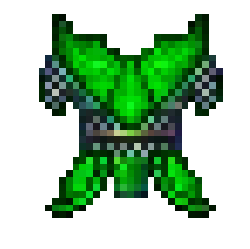

In [69]:
plt.tight_layout()
plt.imshow(resultImg)
plt.axis('off')

In [0]:
autoencoder.save_weights("drive/autoencoder_weights_staff.h5")
print("Saved model to drive")

Saved model to drive
